In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore') 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data_2/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./drive/MyDrive/SS 2023/Bachelor/Data4/genres_original/{g}'):
        songname = f'./drive/MyDrive/SS 2023/Bachelor/Data4/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data_2/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()


<Figure size 800x800 with 0 Axes>

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./drive/MyDrive/SS 2023/Bachelor/Data4/genres_original/{g}'):
        songname = f'./drive/MyDrive/SS 2023/Bachelor/Data4/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

from keras.optimizers import Adam
opt=Adam(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2 = Sequential()
model2.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ANN_new.h5", monitor='accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early=EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

classifier = model.fit(X_train, y_train, epochs=200, batch_size=64,validation_data=(X_test,y_test),callbacks=[checkpoint, early])

Epoch 1/200

Epoch 1: accuracy improved from -inf to 0.04688, saving model to ANN_new.h5
 1/13 [=>............................] - ETA: 8s - loss: 2.5305 - accuracy: 0.0469
Epoch 1: accuracy improved from 0.04688 to 0.08594, saving model to ANN_new.h5

Epoch 1: accuracy did not improve from 0.08594
 3/13 [=====>........................] - ETA: 0s - loss: 2.4885 - accuracy: 0.0833
Epoch 1: accuracy improved from 0.08594 to 0.08984, saving model to ANN_new.h5

Epoch 1: accuracy did not improve from 0.08984
 5/13 [==========>...................] - ETA: 0s - loss: 2.5044 - accuracy: 0.0844
Epoch 1: accuracy did not improve from 0.08984

Epoch 1: accuracy did not improve from 0.08984

Epoch 1: accuracy did not improve from 0.08984

Epoch 1: accuracy improved from 0.08984 to 0.09375, saving model to ANN_new.h5
 9/13 [===================>..........] - ETA: 0s - loss: 2.5117 - accuracy: 0.0938
Epoch 1: accuracy improved from 0.09375 to 0.09687, saving model to ANN_new.h5
10/13 [================

In [ ]:
model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 6ms/step - loss: 1.3617 - accuracy: 0.4650


[1.361680269241333, 0.4650000035762787]

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

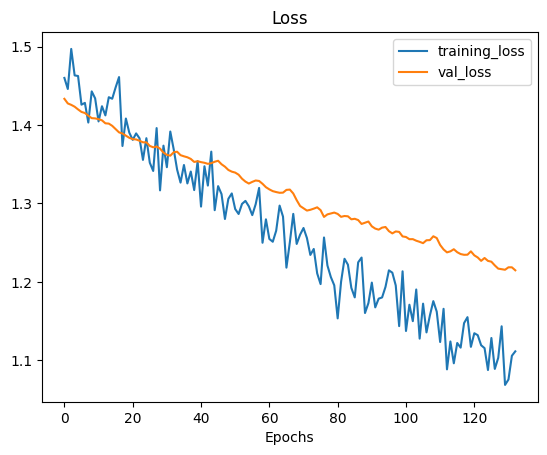

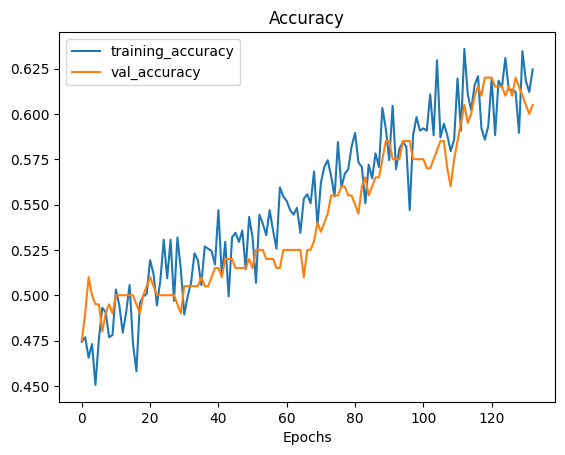

In [ ]:
plot_loss_curves(classifier)

In [ ]:
hist = model2.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,validation_data=(X_test,y_test))

Epoch 1/100
7/7 [==============================] - 0s 59ms/step - loss: 0.0133 - accuracy: 0.9987 - val_loss: 1.6854 - val_accuracy: 0.6600
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0152 - accuracy: 0.9987 - val_loss: 1.6850 - val_accuracy: 0.6600
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0136 - accuracy: 0.9987 - val_loss: 1.6855 - val_accuracy: 0.6650
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0128 - accuracy: 0.9975 - val_loss: 1.7064 - val_accuracy: 0.6700
Epoch 5/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0129 - accuracy: 0.9975 - val_loss: 1.7061 - val_accuracy: 0.6700
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0129 - accuracy: 0.9987 - val_loss: 1.7061 - val_accuracy: 0.6550
Epoch 7/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 1.7258 - val_accuracy: 0.6600
Epoch 8/100
7/7 [===

In [ ]:
model2.evaluate(X_test,y_test)

7/7 [==============================] - 0s 10ms/step - loss: 2.1060 - accuracy: 0.6600


[2.1060073375701904, 0.6600000262260437]

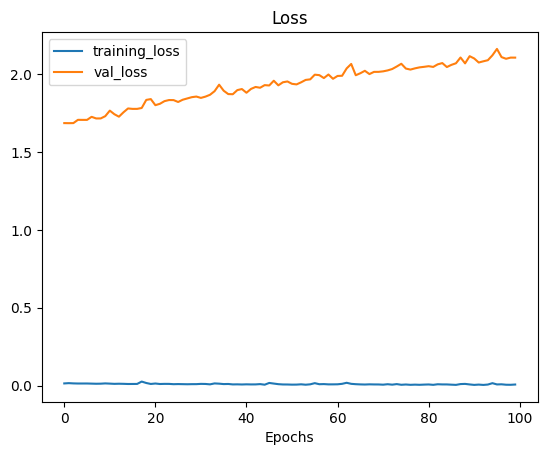

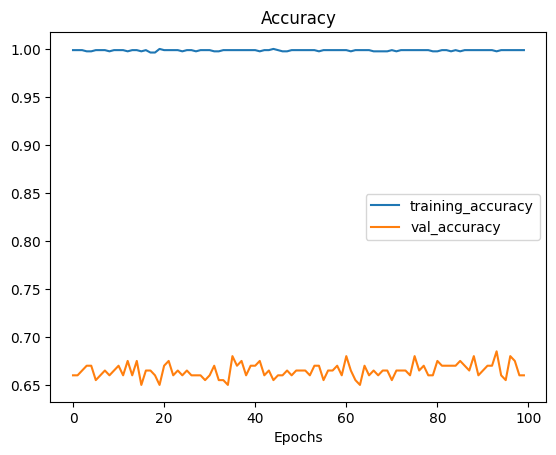

In [ ]:
plot_loss_curves(hist)

In [ ]:
model3 = Sequential()
model3.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(10, activation='softmax'))
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist2 = model3.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,validation_data=(X_test,y_test))

Epoch 1/100
7/7 [==============================] - 2s 58ms/step - loss: 2.2486 - accuracy: 0.1715 - val_loss: 2.0742 - val_accuracy: 0.3050
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 2.0040 - accuracy: 0.3079 - val_loss: 1.9183 - val_accuracy: 0.3600
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 1.8835 - accuracy: 0.3454 - val_loss: 1.7957 - val_accuracy: 0.3700
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 1.7158 - accuracy: 0.3967 - val_loss: 1.6806 - val_accuracy: 0.3850
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 1.6188 - accuracy: 0.4218 - val_loss: 1.5905 - val_accuracy: 0.4200
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 1.5326 - accuracy: 0.4418 - val_loss: 1.5093 - val_accuracy: 0.4500
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 1.4593 - accuracy: 0.4656 - val_loss: 1.4454 - val_accuracy: 0.4850
Epoch 8/100
7/7 [===

In [ ]:
model3.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.1579 - accuracy: 0.6800


[1.157914638519287, 0.6800000071525574]

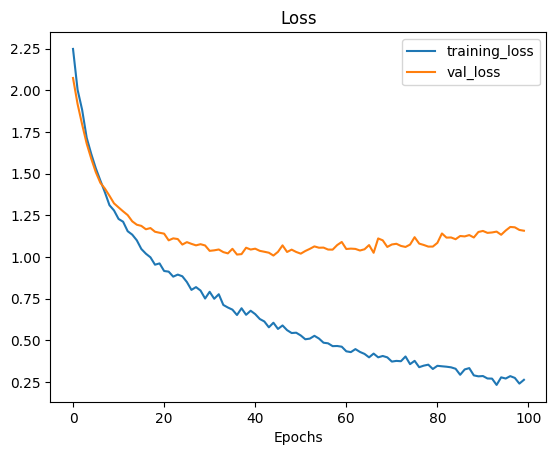

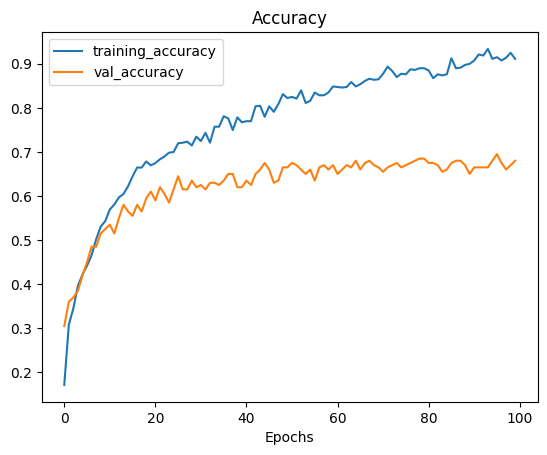

In [ ]:
plot_loss_curves(hist2)

In [ ]:
model4 = Sequential()
model4.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='softmax'))
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist3 = model4.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=128,validation_data=(X_test,y_test))

Epoch 1/200
7/7 [==============================] - 2s 47ms/step - loss: 2.4346 - accuracy: 0.1039 - val_loss: 2.1822 - val_accuracy: 0.3200
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 2.2948 - accuracy: 0.1527 - val_loss: 2.1193 - val_accuracy: 0.3500
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 2.1580 - accuracy: 0.2115 - val_loss: 2.0503 - val_accuracy: 0.3700
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 2.0937 - accuracy: 0.2428 - val_loss: 1.9690 - val_accuracy: 0.3500
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 2.0337 - accuracy: 0.2741 - val_loss: 1.8922 - val_accuracy: 0.3650
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 1.9718 - accuracy: 0.2753 - val_loss: 1.8224 - val_accuracy: 0.3650
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.9423 - accuracy: 0.2954 - val_loss: 1.7738 - val_accuracy: 0.4000
Epoch 8/200
7/7 [===

In [ ]:
model4.evaluate(X_test,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 1.1135 - accuracy: 0.6750


[1.1135292053222656, 0.675000011920929]

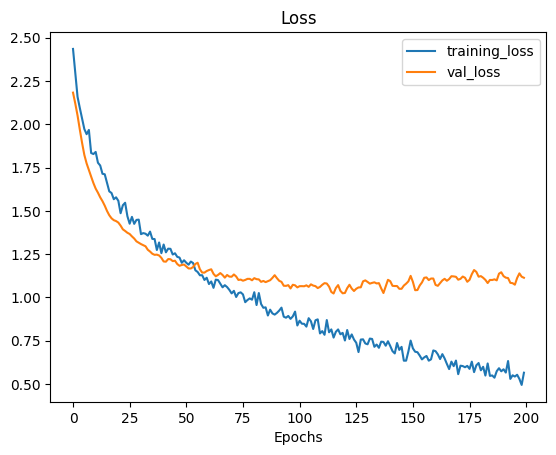

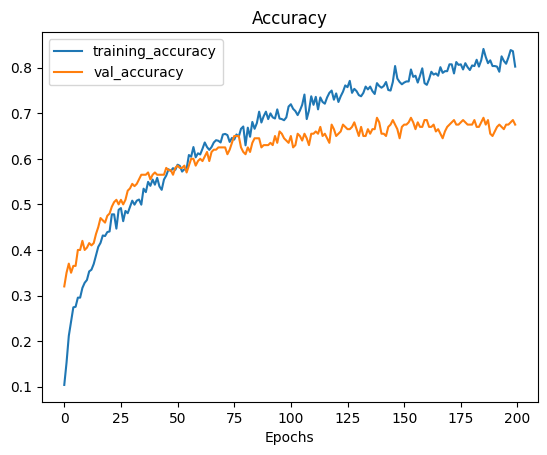

In [ ]:
plot_loss_curves(hist3)

In [ ]:
model5 = Sequential()
model5.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='softmax'))
model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist4 = model5.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,validation_data=(X_test,y_test))

Epoch 1/100
25/25 [==============================] - 2s 11ms/step - loss: 2.3244 - accuracy: 0.1577 - val_loss: 2.0935 - val_accuracy: 0.3350
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 2.0942 - accuracy: 0.2228 - val_loss: 1.9204 - val_accuracy: 0.3450
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 1.9715 - accuracy: 0.2816 - val_loss: 1.7971 - val_accuracy: 0.3600
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 1.8683 - accuracy: 0.3141 - val_loss: 1.7213 - val_accuracy: 0.3500
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 1.8121 - accuracy: 0.3630 - val_loss: 1.6731 - val_accuracy: 0.3650
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 1.7301 - accuracy: 0.3755 - val_loss: 1.6228 - val_accuracy: 0.3900
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 1.7295 - accuracy: 0.4005 - val_loss: 1.6025 - val_accuracy: 0.4150
Epoch 8/100


In [ ]:
model5.evaluate(X_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.1657 - accuracy: 0.6550


[1.1657317876815796, 0.6549999713897705]

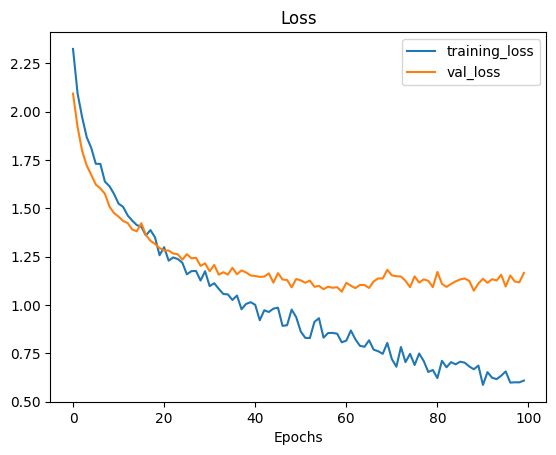

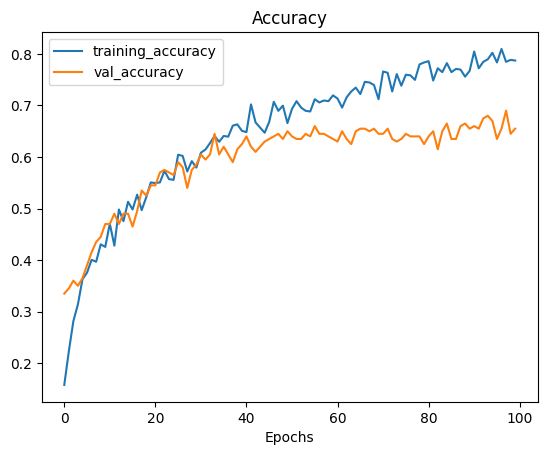

In [ ]:
plot_loss_curves(hist4)

In [ ]:
model6 = Sequential()
model6.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(128, activation='relu'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(10, activation='softmax'))
model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist5 = model6.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,validation_data=(X_test,y_test))

Epoch 1/200
13/13 [==============================] - 3s 35ms/step - loss: 2.4247 - accuracy: 0.1139 - val_loss: 2.1603 - val_accuracy: 0.3050
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 2.2098 - accuracy: 0.1902 - val_loss: 2.0642 - val_accuracy: 0.3350
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 2.0862 - accuracy: 0.2528 - val_loss: 1.9452 - val_accuracy: 0.3350
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 1.9798 - accuracy: 0.2841 - val_loss: 1.8223 - val_accuracy: 0.3400
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 1.9287 - accuracy: 0.3054 - val_loss: 1.7483 - val_accuracy: 0.3500
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 1.8662 - accuracy: 0.3267 - val_loss: 1.6987 - val_accuracy: 0.4050
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 1.8258 - accuracy: 0.3429 - val_loss: 1.6539 - val_accuracy: 0.4050
Epoch 

In [ ]:
model6.evaluate(X_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.2198 - accuracy: 0.6900


[1.2198413610458374, 0.6899999976158142]

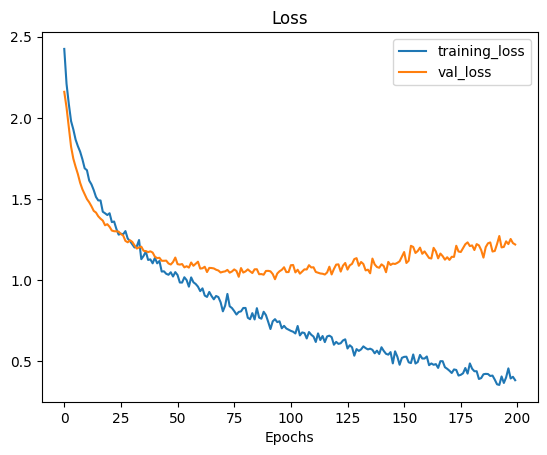

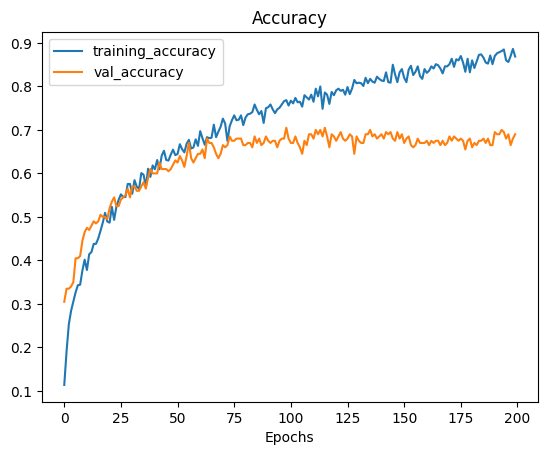

In [ ]:
plot_loss_curves(hist5)

In [ ]:
model7 = Sequential()
model7.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(128, activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(10, activation='softmax'))
model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("ANN_new.h5", monitor='accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early=EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

hist6 = model7.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,validation_data=(X_test,y_test),callbacks=[checkpoint,early])

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 4: accuracy did not improve from 0.35938

Epoch 4: accuracy did not improve from 0.35938

Epoch 4: accuracy did not improve from 0.35938

Epoch 4: accuracy did not improve from 0.35938
25/25 [==============================] - 0s 10ms/step - loss: 1.9512 - accuracy: 0.2941 - val_loss: 1.7891 - val_accuracy: 0.3650
Epoch 5/100

Epoch 5: accuracy improved from 0.35938 to 0.40625, saving model to ANN_new.h5
 1/25 [>.............................] - ETA: 0s - loss: 1.8286 - accuracy: 0.4062
Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625

Epoch 5: accuracy did not improve from 0.40625
 9/25 [=========>....................] - ETA: 0s - los

In [ ]:
model7.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.1452 - accuracy: 0.6600


[1.1452473402023315, 0.6600000262260437]

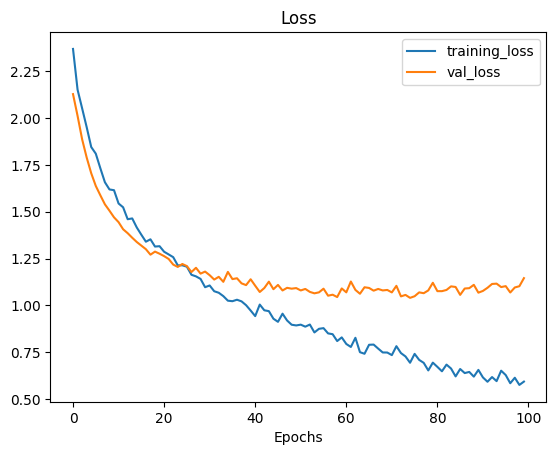

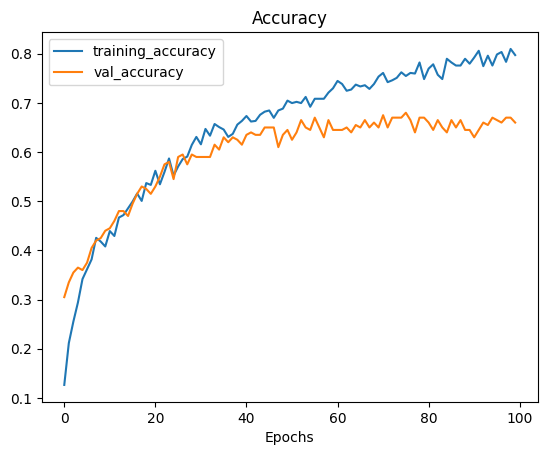

In [ ]:
plot_loss_curves(hist6)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 4: accuracy did not improve from 0.21875

Epoch 4: accuracy did not improve from 0.21875

Epoch 4: accuracy did not improve from 0.21875
25/25 [==============================] - 0s 13ms/step - loss: 2.3738 - accuracy: 0.1277 - val_loss: 2.2074 - val_accuracy: 0.2700
Epoch 5/100

Epoch 5: accuracy did not improve from 0.21875
 1/25 [>.............................] - ETA: 0s - loss: 2.3317 - accuracy: 0.1562
Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875
 8/25 [========>.....................] - ETA: 0s - loss: 2.2764 - accuracy: 0.1875
Epoch 5: accuracy did not improve from 0.21875

Epoch 5: accuracy did not improve from 0.21875

Epo

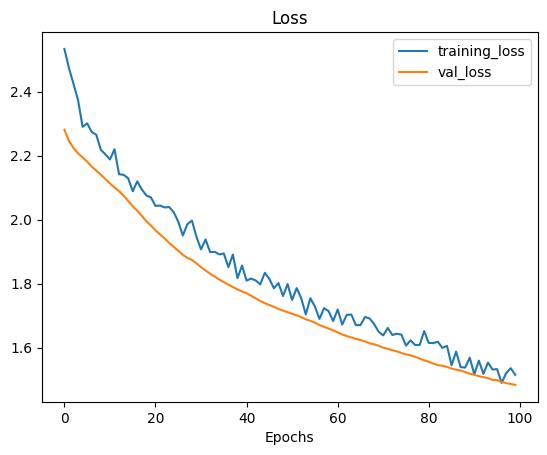

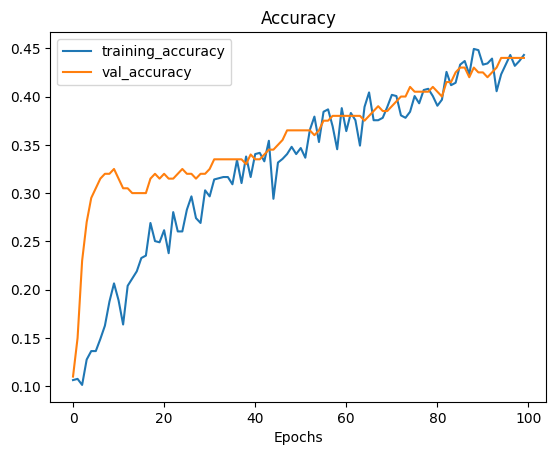

In [ ]:
model8 = Sequential()
model8.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model8.add(layers.Dropout(0.5))
model8.add(layers.Dense(128, activation='relu'))
model8.add(layers.Dropout(0.5))
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dropout(0.5))
model8.add(layers.Dense(10, activation='softmax'))
opt=Adam(learning_rate=1e-4)
model8.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("ANN_new.h5", monitor='accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early=EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

hist7 = model8.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,validation_data=(X_test,y_test),callbacks=[checkpoint,early])
model8.evaluate(X_test,y_test)
plot_loss_curves(hist7)

Epoch 1/200

Epoch 1: accuracy improved from -inf to 0.10938, saving model to C:/Users/alexa/Documents/Studium/Bachelor/ANN_new.h5
 1/13 [=>............................] - ETA: 10s - loss: 2.8400 - accuracy: 0.1094
Epoch 1: accuracy improved from 0.10938 to 0.13281, saving model to C:/Users/alexa/Documents/Studium/Bachelor/ANN_new.h5

Epoch 1: accuracy did not improve from 0.13281
 3/13 [=====>........................] - ETA: 0s - loss: 2.6673 - accuracy: 0.1042 
Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281
 8/13 [=================>............] - ETA: 0s - loss: 2.5780 - accuracy: 0.1152
Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy did not improve from 0.13281

Epoch 1: accuracy 

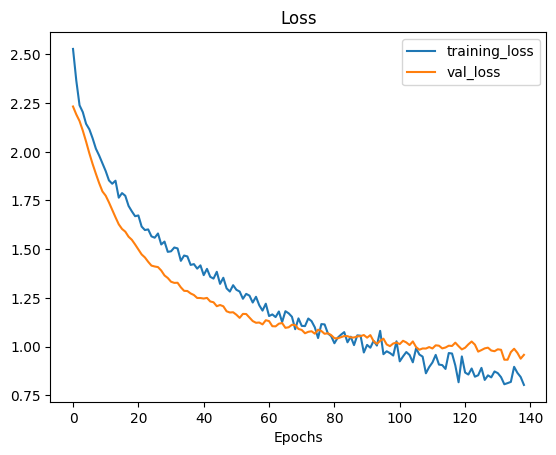

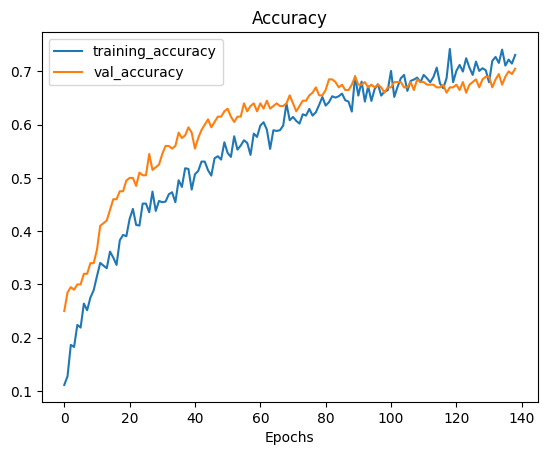

In [ ]:
model9 = Sequential()
model9.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model9.add(layers.Dropout(0.58))
model9.add(layers.Dense(128, activation='relu'))
model9.add(layers.Dropout(0.58))

model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dropout(0.58))
model9.add(layers.Dense(10, activation='softmax'))
opt=Adam(learning_rate=0.001)
model9.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("C:/Users/alexa/Documents/Studium/Bachelor/ANN_new.h5", monitor='accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early=EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

hist8 = model9.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64 ,validation_data=(X_test,y_test),callbacks=[checkpoint,early])
model9.evaluate(X_test,y_test)
plot_loss_curves(hist8)

In [1]:
model9.save("C:/Users/alexa/Documents/Studium/Bachelor/ANN.h5")

NameError: ignored

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
            

Confusion Matrix Calculating ...
7/7 [==============================] - 0s 3ms/step
Normalized confusion matrix


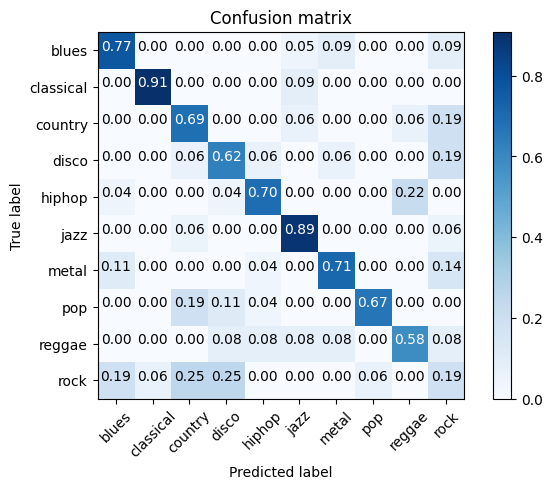

In [ ]:
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix Calculating ...')
preds = np.argmax(model9.predict(X_test),axis=1)
y_orig = y_test
cm = confusion_matrix(preds, y_orig)

genres={'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8, 'rock':9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plot_confusion_matrix(cm,keys,normalize=True)
plt.show()

# **References**

Source: Chauhan, N. S. (2021, September 20). Audio Data Analysis Using Deep Learning with Python (Part 1). The AI Dream. Retrieved April 20, 2023, from https://www.theaidream.com/post/audio-data-analysis-using-deep-learning-with-python-part-1

From: Ahmad, F., & Sahil, N. (2019) Plot_CM.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/Plot_CM.py

From: Ahmad, F., & Sahil, N. (2019) CNN_Model.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/CNN_Model.py

Source: Bourke, D. (2020). 03. Convolutional Neural Networks and Computer Vision with TensorFlow: Multi-class Classification. Zero to Mastery TensorFlow for Deep Learning. Retrieved April 14, 2023, from https://dev.mrdbourke.com/tensorflow-deep-learning/03_convolutional_neural_networks_in_tensorflow/#multi-class-classification